In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
from copy import copy

In [2]:
P = 16

In [3]:
def print_mat(MAT, Format = '%.0f '):
    for r in MAT:
        Line = ''
        for c in r:     
            Line += (Format%(c))  
        print(Line)

def Draw_mat(M, colorbar=False,Figsize = [5,5],title = None,Color=[1,1,1,1]):
    global P
    plt.figure(figsize = Figsize)
    
    for i in np.arange(0.5,P-1,1.0):
        plt.axhline(y=i, xmin=-0.5, xmax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
        plt.axvline(x=i, ymin=-0.5, ymax=P-0.5, linewidth=2, color=(0.5,0.5,0.5))
    plt.imshow(M if colorbar else 1-M, cmap = plt.cm.hot, interpolation = 'nearest')
    
    plt.xticks(range(0,M.shape[1],4),color=Color)
    plt.yticks(range(0,M.shape[0],4),color=Color)
    plt.tick_params(axis='x', colors=Color)
    plt.tick_params(axis='y', colors=Color)
    
    if title:
        plt.title(title,color=Color)
    
    if colorbar:
        plt.colorbar(ticks=range((int)(np.max(M))+1), orientation='vertical')
    
    plt.show()

In [4]:
def Get_ADJ(file_path):
    F = pd.read_csv(file_path, delimiter = ' ', header = None)
    return (F.values).astype('float32')

def Get_Static_Table(file_path):
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        seq = []
        for ele in line[2:]:
            seq.append((int)(ele))
            
        Table[((int)(l),(int)(r))] = seq
    
    F.close()
    
    return Table

In [5]:
Target_Topology = '16k4torus'

Adj = Get_ADJ('topology/%s.adj'%Target_Topology)
SRTable = Get_Static_Table('topology/%s_Static.srt'%Target_Topology)

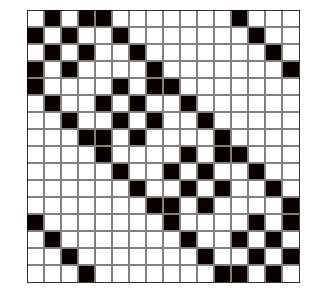

In [6]:
Draw_mat(Adj)

# Distance Matrix

In [7]:
I_P = np.identity(P)

In [8]:
def smoothstep(x):
    R,C = x.shape
    for r in range(R):
        for c in range(C):
            if x[c][r] > 1:
                x[c][r] = 1
                
def Generate_RouteTree(A_now, D_now):
    global I_P
    D_next = np.matmul(I_P+Adj,D_now)
    smoothstep(D_next)
    return A_now, D_next

In [9]:
A = copy(Adj)
step = 0
D = np.identity(P)
Routines = []
DIST_M = np.zeros([P,P],dtype='int16')
while (np.min(D) == 0):
    A,D_N = Generate_RouteTree(A,D)
    Routines.append(np.transpose(D_N - D))
    step += 1
    DIST_M += step*(D_N - D).astype('int16')
    D = D_N

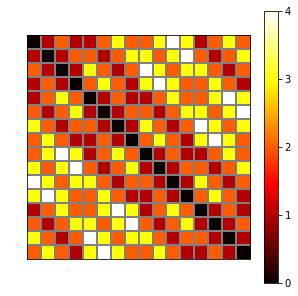

In [10]:
Draw_mat(DIST_M,colorbar=True,Figsize=[5,5],title='distance matrix')

# Find Routine

In [11]:
import csv

In [12]:
def get_BAMMA(filepath, rank_map = None):
    global P
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
    
    Algorithm = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = rank_map[(int)(line[0][1:])]
            Algorithm[rank] = []   # add node
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    Algorithm[rank].append(('C',Vol))
                    i += 3
                elif line[i] == 'S': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('S',rank_map[(int)(line[i+1])],Area))
                    i += 3
                elif line[i] == 'R': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('R',rank_map[(int)(line[i+1])],Area))
                    i += 3
                    
                    
                i += 1
    F.close()            
    return Algorithm

In [13]:
def Extract_cycles(filepath, rank_map = None):
    global P
    
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
        
    Ideal = np.zeros([P,P],dtype='int16')
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        At = rank_map[(int)(line[0][1:])]
        ind = 1
        for ele in line[1:]:
            if ele == 'S':
                Ideal[At][rank_map[(int)(line[ind+1])]] += 1
                Ideal[rank_map[(int)(line[ind+1])]][At] += 1
            ind += 1
            
    return Ideal

In [14]:
def Get_Loss(Res_M, Alg_M):
    Loss_M = Res_M * (Alg_M>0).astype('int16')
    return np.max(Loss_M), np.mean(Loss_M**5)

In [15]:
def switch_nodes(M,_Map = None):
    if not _Map:
        _Map = {i:i for i in range(M.shape[0])}
    Res = copy(M)
    for src,to in _Map.items():
        Res[to,:] = M[src,:]
    Res1 = copy(Res)
    for src,to in _Map.items():
        Res1[:,to] = Res[:,src]
    return Res1

In [16]:
def Get_Exchange(Map):
    E_M = np.zeros([len(Map),len(Map)])
    for i in range(len(Map)):
        E_M[i][Map[i]] = 1
        E_M[Map[i]][i] = 1
    return E_M

def get_OptMap(Topo_M,Alg_M):
    P_ = Topo_M.shape[0]
    E = np.identity(P_)
    
    eigval_T,eigvec_T = np.linalg.eig(Topo_M)
    eigval_A,eigvec_A = np.linalg.eig(Alg_M)
    
    weight_T = np.sqrt(np.abs(eigval_T))*np.transpose(eigvec_T)
    weight_A = np.sqrt(np.abs(eigval_A))*np.transpose(eigvec_A)
    
    DDM = np.zeros([P_,P_])
    for i in range(P_):
        for j in range(P_):
            DDM[i,j] = np.linalg.norm(weight_T[:,i]-weight_A[:,j])
            
    
    Map = {i:i for i in range(P_)}
    Loss = 1
    return Map,Loss

# Static Routine

In [17]:
def Route_On_Static(Sender,Reciever,RTable,status,area):
    Act_to_Add = {p:[] for p in range(len(status))}
    Route = RTable[(Sender,Reciever)]
    
    # Sequencial
    prev = Sender
    for p in Route:
        # Waiting Time
        # update status
        if status[p] > status[prev]:
            Act_to_Add[prev].append(('W',status[p]-status[prev]))
            status[prev] = status[p]
        elif status[p] < status[prev]:
            Act_to_Add[p].append(('W',status[prev]-status[p]))
            status[p] = status[prev]
        
        # Comm Time
        Act_to_Add[prev].append(('S',area))
        Act_to_Add[p].append(('R',area))
        status[p] += area
        status[prev] += area
        
        # next pair
        prev = copy(p)

    return Act_to_Add

In [18]:
def Real_Routine(Raw_Route,Adj_M):
    # get num of actions vs each node
    Total_P = len(Raw_Route)

    lengths = np.zeros(Total_P,dtype='int32')

    for r,line in Raw_Route.items():
        lengths[r] = len(line)

    # Result
    Routine = {i:[] for i in range(Total_P)}
    # Nodes Status
    # 0:idle >0:length of queue
    Status = np.zeros(Total_P,dtype='int64')
    
        
    # BFS
    p = 0
    process = np.zeros(Total_P,dtype='int32')
    while True:
        # Finished
        if np.max(np.abs(lengths-process)) == 0:
            return Routine
        # finished nodes
        if lengths[p] == process[p]:
            p = (p+1)%Total_P
            continue
        
        Action = Raw_Route[p][process[p]]
        
        # overhead
        global SRTable
        Status -= np.min(Status)  # processing

        if Action[0] == 'C':      # Computation
            Routine[p].append(Action)
            # add queue
            Status[p] += Action[-1]
        elif Action[0] == 'S':    # Send
            Acts = Route_On_Static(p,Action[1],SRTable,Status,Action[-1])

            for pp,act in Acts.items():
                Routine[pp] += act
            
        #elif Action[0] == 'R':    # Recieve
        #    pass # done by sender
            
        
        
        # Update
        process[p] += 1
        p = (p+1)%Total_P
   
    return Routine

# Draw Table

In [19]:
def get_Longest(Routes):
    Total_P = len(Routes)
    x_max = 0
    for p in range(Total_P):
        m_xmax = 0
        for act in Routes[p]:
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
    return x_max

In [20]:
Unmap_Routine = Extract_cycles('BAMMA/P16_Fox441.csv')

# Routine Tensor

In [21]:
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm

In [22]:
def get_RoutineTensor(file_path):
    global P
    Tensor = np.zeros([P,P,P],dtype = 'int16')
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        ind = 1
        for ele in line[2:]:
            Tensor[(int)(l)][(int)(r)][(int)(ele)] = ind
            ind += 1
    
    F.close()
    
    return Tensor

In [23]:
Routint_Tensor = get_RoutineTensor('topology/%s_Static.srt'%Target_Topology)

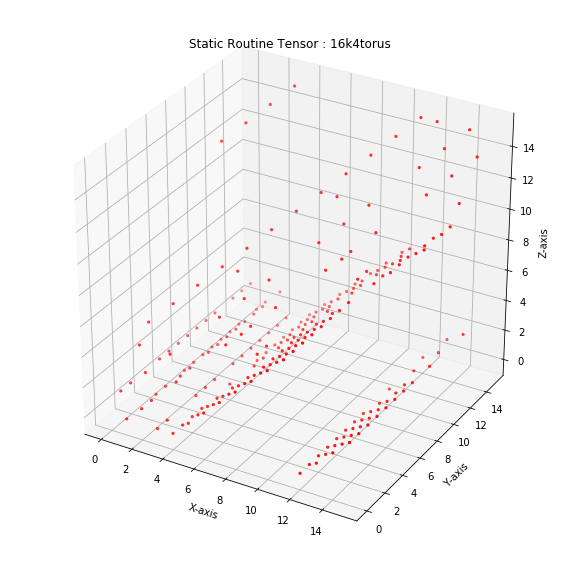

In [24]:
Fig_Tensor = plt.figure(figsize=[10,10])
ax = Fig_Tensor.add_subplot(1, 1, 1, projection='3d')

x_val = []
y_val = []
z_val = []
for i in range(P):
    for j in range(P):
        for k in range(P):
            if Routint_Tensor[i][j][k] == 1:
                x_val.append(i)
                y_val.append(j)
                z_val.append(k)
#ax.scatter(np.arange(P),np.arange(P),np.arange(P),c = 'gray', marker='.')
ax.scatter(x_val,y_val,z_val,c = 'r', marker='.')           
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title('Static Routine Tensor : %s'%Target_Topology)
plt.show()

In [25]:
def Get_Saturability(Route_Tensor, Comm_M):
    global P
    Ser = np.zeros(P,dtype='int16')
    i = 0
    for z in range(P):
        Ser[i] = np.sum(Route_Tensor[:,:,z]*Comm_M)
        i += 1
    return Ser

In [26]:
# fixed Center
Center = {
    0:0,
    1:1,
    2:9,
    3:8,        
    4:2,
    5:3,
    6:11,
    7:10,
    8:-1,
    9:-1,
    10:-1,
    11:-1,
    12:-1,
    13:-1,
    14:-1,
    15:-1,
}
Leaf = []
for i in range(P):
    if i not in Center.values():
        Leaf.append(i)

In [27]:
def Shuffle_with_Center(center,leaf):
    global P
    new_center = copy(center)
    np.random.shuffle(leaf)
    ind = 0
    for i in range(P):
        if new_center[i] < 0:
            new_center[i] = leaf[ind]
            ind += 1
    return new_center

In [28]:
pairs = []
TT = 0
for T in range(0):
    #rand_series = np.random.permutation(np.arange(P))
    #random_map = {i:rand_series[i] for i in range(P)}
    random_map = Shuffle_with_Center(Center,Leaf)
    New_M = switch_nodes(Unmap_Routine,random_map)
    Diam,mean_d = Get_Loss(DIST_M, New_M)
    #Ser = Get_Saturability(Routint_Tensor,New_M)
    ExM = Get_Exchange(Shuffle_with_Center(Center,Leaf))
    T_Routine = get_BAMMA('BAMMA/P16_Fox441.csv',rank_map=random_map)
    m_time = get_Longest(Real_Routine(T_Routine,Adj))
    eigVal = np.linalg.eigvals(ExM)
    #pairs.append((np.std(Ser,ddof=1),np.sum(Ser),m_time))
    pairs.append((max(abs(eigVal)),min(eigVal),m_time))
    if T > TT + 99:
        print(T)
        TT = T

# Fetching Data

In [29]:
def Get_Saturability_Seq(Route_Tensor, Comm_M, MAP):
    global P
    Ser = np.zeros(P,dtype='int16')
    i = 0
    for z in range(P):
        Ser[MAP[i]] = np.sum(Route_Tensor[:,:,z]*Comm_M)
        i += 1
    return Ser

In [38]:
Data = []
TT = 0
for T in range(1000):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    #random_map = Shuffle_with_Center(Center,Leaf)
    New_M = switch_nodes(Unmap_Routine,random_map)
    New_M = New_M/np.max(New_M)
    Ser = Get_Saturability_Seq(Routint_Tensor,New_M,random_map)
    T_Routine = get_BAMMA('BAMMA/P16_Fox441.csv',rank_map=random_map)
    m_time = get_Longest(Real_Routine(T_Routine,Adj))
    Data.append((Ser,m_time))
    if T > TT + 99:
        print(T)
        TT = T

100
200
300
400
500
600
700
800
900


In [39]:
X1 = []
X2 = []
Y = []
for d in Data:
    X1.append(np.max(d[0]))
    X2.append(np.std(d[0],ddof=1))
    Y.append(d[1])
X1 = np.array(X1)
X2 = np.array(X2)
Y = np.array(Y)

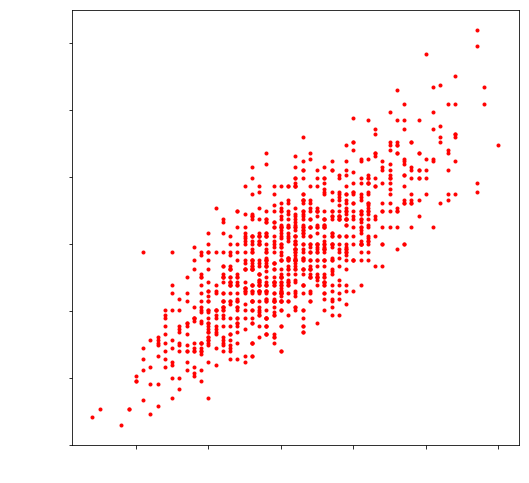

In [40]:
T_Fig = plt.figure(figsize=(8,8))
axT = T_Fig.add_subplot(1, 1, 1)
w = 1
axT.plot(w*X1+(1-w)*X2,Y,'r.')           
axT.set_xlabel('Saturability',color='white')
axT.set_ylabel('Time',color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.show()

In [33]:
with open('seqData_1e6_16k3wheel2_BMR441.dat','w') as F:
    for l in Data:
        line = ''.join('%i,'%d for d in l[0])
        line += '%i,'%l[1]
        F.write(line[:-1])
        F.write('\n')

F.close()

# analytic convergence

In [34]:
Min_SS = np.inf
Min_SM = np.inf
good_Ser = None
TT = 0
for T in range(100000):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    #random_map = Shuffle_with_Center(Center,Leaf)
    New_M = switch_nodes(Unmap_Routine,random_map)
    New_M = New_M/np.max(New_M)
    Ser = Get_Saturability_Seq(Routint_Tensor,New_M,random_map)
    m_Ser = max(Ser)
    s_Ser = sum(Ser)
    if m_Ser < Min_SM:
        Min_SS = s_Ser
        Min_SM = m_Ser
        good_Ser = copy(random_map)
    elif m_Ser == Min_SM:
        if s_Ser < Min_SS:
            Min_SS = s_Ser
            good_Ser = copy(random_map)
    if T > TT + 9999:
        print(T,Min_SS,Min_SM)
        TT = T
print('-->',Min_SS,Min_SM)

10000 308 28
20000 308 28
30000 308 28
40000 308 28
50000 308 28
60000 308 28
70000 308 28
80000 308 28
90000 308 28
--> 308 28


In [35]:
T_Routine = get_BAMMA('BAMMA/P16_Fox441.csv',rank_map=good_Ser)
print(get_Longest(Real_Routine(T_Routine,Adj)))

1462272
